<center><h1>Calculating the second virial coefficient ... </h1></center>
<center><h2>... or the importance of vectorizing </h2></center>

We want to calculate the second virial coefficient for a system of hard spherocylinders using Monte Carlo integration.

We shall start by coding this in as we would if we were using C or Fortran.

First, we import some libraries/modules

In [1]:
import numpy as np                     #we always need arrays
import pandas as pd                    #we want to put our results in a table
import matplotlib.pyplot as plt        #and we wouldn't mind plotting them
from scipy.optimize import brentq      #we will need to find the root of a function
import time                            #and of course, we want to time everything

We now need to define a few functions: the following two are used to find the value of alpha for a given nematic order parameter

In [2]:
def nematic_orderparam(alpha, S2):
    """Function to calculate the nematic order parameter for a given alpha, minus a guess"""
    return 1.0 + 3.0/(alpha*alpha) - 3.0/(alpha*np.tanh(alpha))-S2

In [3]:
def find_alpha(S2):
    """Function to find the alpha for a given nematic order parameter"""
    return brentq(nematic_orderparam, 1e-10, 2e3, args = (S2))

Now we define three functions to generate a unit vector for three different systems:
 - iso: the isotropic phase, where the particles point in each direction with equal chance
 - nem: a perfectly aligned nematic phase, where all the particles point straight up
 - onsager: generates a unit vector from the Onsager distribution function, for a given nematic order parameter

In [4]:
def iso():
    """Generate a unit vector for a particle in the isotropic phase"""
    u = np.empty(3)
    u[2] = np.random.uniform()
    x = twopi*np.random.uniform()
    fac = np.sqrt(1.0-u[2]*u[2])
    u[0] = fac*np.cos(x)
    u[1] = fac*np.sin(x)
    return u

In [5]:
def nem():
    """Generate a unit vector for a particle in a perfectly aligned nematic phase"""
    u = np.zeros(3)
    u[2] = 1.0
    return u

In [6]:
def onsager(S2, alpha, sh_alpha):
    """Generate a unit vector from the Onsage trial function for a given nematic order parameter S2"""
    u = np.empty(3)
    x = np.random.uniform()*sh_alpha
    u[2] = np.log(x + np.sqrt(1.0 + x*x))/alpha
    x = twopi*np.random.uniform()
    fac = np.sqrt(1.0-u[2]*u[2])
    u[0] = fac*np.cos(x)
    u[1] = fac*np.sin(x)
    return u

And we also define a function to test for overlaps between particles

In [7]:
def overlap(sep,ui,uj):
    """Test for overlaps between two spherocylinders: returns True if they do"""
    over = False
    rui   = np.sum(sep*ui)
    ruj   = np.sum(sep*uj)
    uij   = np.sum(ui*uj)
    sinsq = 1.0 - np.sum(uij*uij)
    if sinsq < 1e-14:
        ci = -rui*0.5
        cj = ruj*0.5
    else:
        ci = (-rui+uij*ruj)/sinsq
        cj = (ruj-uij*rui)/sinsq
    if np.maximum(np.absolute(ci), np.absolute(cj)) >= xld2:
        if np.absolute(ci) >= np.absolute(cj):
            ci = xld2*np.sign(ci)
            cj = ruj + ci*uij
        else:
            cj = xld2*np.sign(cj)
            ci = -rui + cj*uij
        if np.absolute(ci) > xld2:
            ci = xld2*np.sign(ci)
        if np.absolute(cj) > xld2:
            cj = xld2*np.sign(cj)
    di = 2.0*rui  + ci-cj*uij
    dj = -2.0*ruj + cj-ci*uij
    sepsq = np.sum(sep*sep)
    if sepsq + ci*di + cj*dj < 1.0:
        over = True
    return over

And finally we need a function that calculates the value of the virial coefficients.

 - We set a number of S2 values that we want to study (n_points values, ranging from 0 to 1 in equally spaced steps).
 - We also set the number of configurations we will generate. This is split into batches.
 - The funciton returns a dictionary containing the order parameters, the values for the virials and the errors

In [8]:
def onsager_B2(n_batch,n_trial, n_points):
    """Calculate the nematic order parameter using n_batch*n_trial configurations, for n_points order parameters"""
    rmax = 2.0*xld2 + 1.0
    fac = 4.0*rmax*rmax*rmax
    r1 = np.zeros(3)
    u1 = np.zeros(3)
    u2 = np.zeros(3)
    output = {}
    output['S2'] = np.zeros(n_points)
    output['B2'] = np.zeros(n_points)
    output['error'] = np.zeros(n_points)
    for i_s in range(n_points):
        S2 = i_s/(n_points-1)
        if S2 < 1.0 and S2 > 0.0:
            alpha = find_alpha(S2)
            sh_alpha = np.sinh(alpha)
        B2 = 0.0
        B2sq  = 0.0
        error = 0.0
        for ib in range(n_batch):
            B2_sub = 0.0
            n_over = 0.0
            for it in range(n_trial):
                r2 = np.random.uniform(-rmax,rmax,3)
                if S2 < 1e-10:
                    u1 = iso()
                    u2 = iso()
                elif S2 > 1.0-1e-10:
                    u1 = nem()
                    u2 = nem()
                else:
                    u1 = onsager(S2, alpha, sh_alpha)
                    u2 = onsager(S2, alpha, sh_alpha)
                if overlap(r2-r1, u1, u2):
                    n_over += 1.0
            B2_sub = n_over/n_trial
            B2    += B2_sub
            B2sq  += B2_sub*B2_sub
        B2 = B2/n_batch
        B2sq = B2sq/n_batch
        error = np.sqrt((B2sq-B2*B2)/(n_batch-1))
        output['S2'][i_s] =  S2
        output['B2'][i_s] =  B2*fac
        output['error'][i_s] =  error*fac
        print(output['S2'][i_s] ,output['B2'][i_s] ,output['error'][i_s] )
    return output


And now we run it all. We take the time before and after to measure performance. 

We will look at spherocylinders with L/D = 5, which means the parameter xld2 = L/2 = 2.5

In [9]:
twopi = 2.0*np.pi
xld2 = 2.5
t0 = time.clock()
B2 = onsager_B2(200,200,21)
output_table = pd.DataFrame(B2)
output_table = output_table[["S2", "B2", "error"]]
#print(output_table)
t1 = time.clock()
print('')
print('CPU time for loops in Python:', t1-t0)

0.0 37.3032 0.964124071333
0.05 36.5904 0.830183862423
0.1 36.6768 0.877457604697
0.15 37.8216 0.823143177493
0.2 36.3096 0.834233629111
0.25 35.856 0.823429377481
0.3 35.6616 0.85197526753
0.35 35.9856 0.948399722357
0.4 35.1432 0.815232586228
0.45 35.1648 0.84647718393
0.5 33.156 0.823393785884
0.55 33.1128 0.844390381507
0.6 33.372 0.838628744353
0.65 31.86 0.843367978844
0.7 30.8232 0.743012169632
0.75 30.7584 0.822038737304
0.8 29.2896 0.824658479151
0.85 28.7496 0.727012264936
0.9 25.812 0.735884576923
0.95 23.2848 0.714122665026
1.0 18.2952 0.609385987044

CPU time for loops in Python: 61.48626


This took about 1 minute for 200*200 = 40,000 trial configurations. Not that fast.

Now we will rewrite these functions to do as much of the computation as we can vector-wise. This makes it all much faster, since then more of the run takes place in the compiled C/Fortran code that this is all built on, rather than in python loops.


In [10]:
def overlap_vector(sep,ui,uj,n_loop):
    """Function to test for overlaps between particles, takes n_loop configurations at once"""
    rui   = np.sum(sep*ui,axis=1)
    ruj   = np.sum(sep*uj,axis=1)
    uij   = np.sum(ui*uj,axis=1)
    sinsq = 1.0 - uij*uij
    ci = np.empty(n_loop)
    cj = np.empty(n_loop)
    listings = sinsq < 1e-14
    nlistings = ~listings
    ci[listings] = -rui[listings]*0.5
    cj[listings] = ruj[listings]*0.5
    ci[nlistings] = (-rui[nlistings]+uij[nlistings]*ruj[nlistings])/sinsq[nlistings]
    cj[nlistings] = (ruj[nlistings]-uij[nlistings]*rui[nlistings])/sinsq[nlistings]
    listings = (np.maximum(np.absolute(ci), np.absolute(cj)) >= xld2) & (np.absolute(ci) >= np.absolute(cj))
    ci[listings] = xld2*np.sign(ci[listings])
    cj[listings] = ruj[listings] + ci[listings]*uij[listings]
    listings = (np.maximum(np.absolute(ci), np.absolute(cj)) >= xld2) & (np.absolute(ci) < np.absolute(cj))
    cj[listings] = xld2*np.sign(cj[listings])
    ci[listings] = -rui[listings] + cj[listings]*uij[listings]
    listings = (np.maximum(np.absolute(ci), np.absolute(cj)) >= xld2) &  (np.absolute(ci) > xld2)
    ci[listings] = xld2*np.sign(ci[listings])
    listings = (np.maximum(np.absolute(ci), np.absolute(cj)) >= xld2) &  (np.absolute(cj) > xld2)
    cj[listings] = xld2*np.sign(cj[listings])
    di = 2.0*rui  + ci-cj*uij
    dj = -2.0*ruj + cj-ci*uij
    sepsq = np.sum(sep*sep, axis=1)
    over = sepsq + ci*di + cj*dj < 1.0
    return over

In [11]:
def iso_vector(n_loop):
    """Generates n_loop unit vectors in the isotropic phase"""
    u = np.empty((n_loop, 3))
    u[:,2] = np.random.uniform(0,1,n_loop)
    x = np.random.uniform(0,twopi,n_loop)
    fac = np.sqrt(1.0-u[:,2]*u[:,2])
    u[:,0] = fac*np.cos(x)
    u[:,1] = fac*np.sin(x)
    return u

In [12]:
def nem_vector(n_loop):
    """Generates n_loop unit vectors in the perfectly aligned nematic phase"""
    u = np.zeros((n_loop, 3))
    u[:,2] = 1.0
    return u

In [13]:
def onsager_vector(S2, alpha, sh_alpha, n_loop):
    """Generates n_loop unit vectors from the Onsager trial function for a given nematic order parameter"""
    u = np.empty((n_loop, 3))
    x = np.random.uniform(0,sh_alpha,n_loop)
    u[:,2] = np.log(x + np.sqrt(1.0 + x*x))/alpha
    x = np.random.uniform(0,twopi,n_loop)
    fac = np.sqrt(1.0-u[:,2]*u[:,2])
    u[:,0] = fac*np.cos(x)
    u[:,1] = fac*np.sin(x)
    return u

In [14]:
def onsager_B2_vectorized(n_loop, n_points):
    """Calculates the second virial coefficient, using n_loop configurations for each of the n_points values of S_nem"""
    rmax = 2.0*xld2 + 1.0
    fact = 4.0*rmax*rmax*rmax
    output = {}
    output['S2'] = np.zeros(n_points)
    output['B2'] = np.zeros(n_points)
    output['error'] = np.zeros(n_points)
    B2_sub = np.empty(n_loop)
    r1 = np.zeros(3)
    for i_s in range(n_points):
        r2 = np.random.uniform(-rmax,rmax,(n_loop,3))
        S2 = i_s/(n_points-1)
        if S2 < 1.0 and S2 > 0.0:
            alpha = find_alpha(S2)
            sh_alpha = np.sinh(alpha)
        if S2 < 1e-10:
            u1 = iso_vector(n_loop)
            u2 = iso_vector(n_loop)
        elif S2 > 1.0-1e-10:
            u1 = nem_vector(n_loop)
            u2 = nem_vector(n_loop)
        else:
            u1 = onsager_vector(S2, alpha, sh_alpha, n_loop)
            u2 = onsager_vector(S2, alpha, sh_alpha, n_loop)
        n_over = overlap_vector(r2-r1, u1, u2, n_loop)
       # n_over = np.zeros(n_loop)
       # for i in range(n_loop):
       #     if overlap(r2[i,:]-r1[:], u1[i,:], u2[i,:]):
       #         n_over[i] += 1.0
        #print(np.sum(n_over), (u1*u1).sum(axis))
        B2 = fact*np.sum(n_over)/n_loop
        error = fact*n_over.std()/np.sqrt(n_loop-1)
        output['S2'][i_s] =  S2
        output['B2'][i_s] =  B2
        output['error'][i_s] =  error
        print(output['S2'][i_s] ,output['B2'][i_s] ,output['error'][i_s] )
    return output

Now we run it all. Before we set n_trial = n_batch = 200, giving 200*200 = 40,000 configurations.

Now we will use n_loop = 2000*2000 = 4,000,000 configurations

In [15]:
twopi = 2.0*np.pi
xld2 = 2.5
t0 = time.clock()
B2_vec = onsager_B2_vectorized(2000*2000,21)
output_table_vec = pd.DataFrame(B2_vec)
output_table_vec = output_table_vec[["S2", "B2", "error"]]
#print(output_table_vec)
t1 = time.clock()
print('')
print('CPU time for vectorized method:', t1-t0)

0.0 37.329984 0.0878344838111
0.05 37.396296 0.0879089365728
0.1 37.334304 0.0878393364567
0.15 37.31076 0.0878128856423
0.2 36.907272 0.0873580905139
0.25 36.685656 0.0871070849809
0.3 36.399024 0.0867811548074
0.35 35.783208 0.0860759274511
0.4 35.48556 0.0857325874764
0.45 34.943184 0.0851027204477
0.5 34.5438 0.0846353594024
0.55 33.789096 0.0837437802892
0.6 32.927904 0.0827125580482
0.65 31.948128 0.0815207126363
0.7 31.113936 0.0804897045733
0.75 30.03048 0.0791272886748
0.8 28.89108 0.0776646712609
0.85 27.40068 0.0757023711425
0.9 25.712424 0.0734071028182
0.95 23.444208 0.0701893327896
1.0 17.73144 0.0612485998757

CPU time for vectorized method: 60.00361


We acheived a similar time of 1minute, but we generated 100x more trial configurations (which means that the error on our result is 10 times smaller).

We now plot the two results, from which the reduction in the error should be visible.

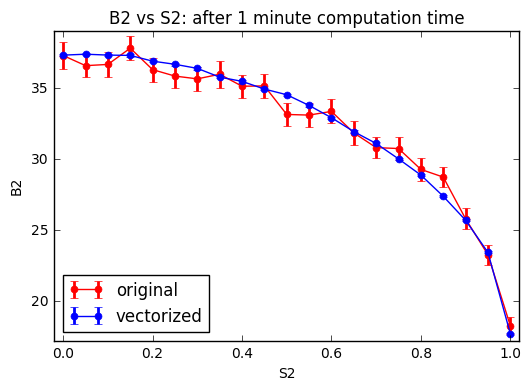

In [16]:
plt.errorbar(output_table.S2, output_table.B2, output_table.error, color = "red", label="original", marker = ".", markersize='10', elinewidth=2)
plt.errorbar(output_table_vec.S2, output_table_vec.B2, output_table_vec.error, color="blue", label = "vectorized", marker = ".", markersize='10', elinewidth=2)
plt.legend(loc="lower left")
plt.xlabel("S2")
plt.ylabel("B2")
plt.margins(0.02)
plt.title("B2 vs S2: after 1 minute computation time")
plt.show()

Of course, the method using loops can be coded in in Fortran, and will run 3.5 times faster than above (so will reduce the error still further, by about a factor of 1.9, for the same computing time. But, if we do want to use python, vectorizing is the way to go.

Let's finish by adding our Fortran result to the plot

In [17]:
fortran_result=pd.read_csv("B2_L5d0_D1d0-race-csv.dat", header=None, names=["S2", "alpha", "B2", "error"])
print(fortran_result)

      S2         alpha         B2     error
0   0.00  0.000000e+00  37.423111  0.045164
1   0.05  8.985869e-01  37.404843  0.047013
2   0.10  1.321999e+00  37.369543  0.046639
3   0.15  1.689315e+00  37.175451  0.046346
4   0.20  2.042078e+00  36.897614  0.046444
5   0.25  2.399357e+00  36.697721  0.046934
6   0.30  2.774537e+00  36.255847  0.045914
7   0.35  3.179995e+00  35.959680  0.045229
8   0.40  3.629410e+00  35.423321  0.045134
9   0.45  4.139693e+00  34.992185  0.045549
10  0.50  4.733319e+00  34.294320  0.045141
11  0.55  5.441841e+00  33.675758  0.044878
12  0.60  6.311799e+00  32.876866  0.044084
13  0.65  7.415565e+00  32.064706  0.042787
14  0.70  8.872984e+00  31.135166  0.042287
15  0.75  1.089898e+01  30.114041  0.041977
16  0.80  1.392262e+01  28.845751  0.041103
17  0.85  1.894427e+01  27.531175  0.040358
18  0.90  2.896424e+01  25.803360  0.040318
19  0.95  5.898275e+01  23.523634  0.037443
20  1.00  1.000000e+14  17.808274  0.031975


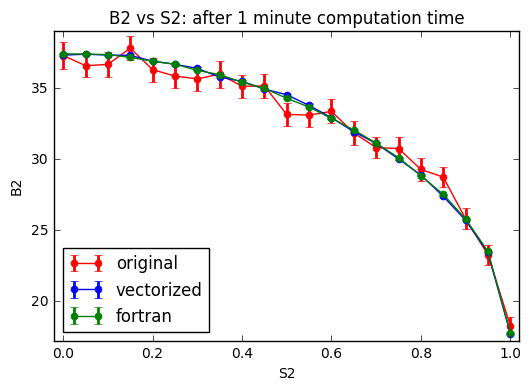

In [18]:
plt.errorbar(output_table.S2, output_table.B2, output_table.error, color = "red", label="original", marker = ".", markersize='10', elinewidth=2)
plt.errorbar(output_table_vec.S2, output_table_vec.B2, output_table_vec.error, color="blue", label = "vectorized", marker = ".", markersize='10', elinewidth=2)
plt.errorbar(fortran_result.S2, fortran_result.B2, fortran_result.error, color="green", label = "fortran", marker = ".", markersize='10', elinewidth=2)
plt.legend(loc="lower left")
plt.xlabel("S2")
plt.ylabel("B2")
plt.margins(0.02)
plt.title("B2 vs S2: after 1 minute computation time")
plt.show()

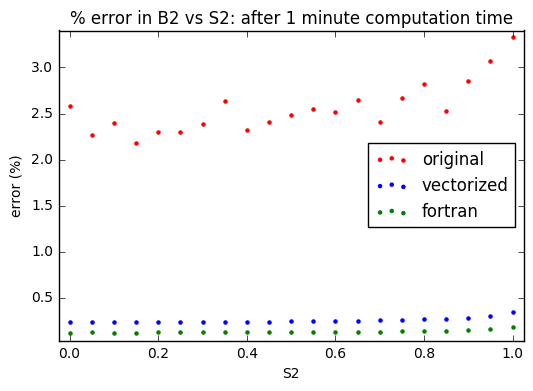

In [19]:
plt.scatter(output_table.S2, (output_table.error/output_table.B2)*100.0, color = "red", label="original", marker = ".")
plt.scatter(output_table_vec.S2, (output_table_vec.error/output_table_vec.B2)*100.0, color="blue", label = "vectorized", marker = ".")
plt.scatter(fortran_result.S2, (fortran_result.error/fortran_result.B2)*100.0, color="green", label = "fortran", marker = ".")
plt.legend(loc="center right")
plt.xlabel("S2")
plt.ylabel("error (%)")
plt.margins(0.02)
plt.title("% error in B2 vs S2: after 1 minute computation time")
plt.show()

And finally, we import a Fortran function we made for B2, which we can call from python

In [20]:
import onsager_B2

In [21]:
t0 = time.clock()
output_table_f2py = pd.DataFrame(np.column_stack(onsager_B2.onsager_b2(5.0,1.0, 10000*1250, 21)),columns=['S2','B2', 'error'])
#output_table_vec = output_table_vec[["S2", "B2", "error"]]
print(output_table_f2py)
t1 = time.clock()
print('')
print('CPU time for imported Fortran function:', t1-t0)

      S2         B2     error
0   0.00  37.441751  0.049789
1   0.05  37.458547  0.049592
2   0.10  37.353900  0.049738
3   0.15  37.142945  0.049524
4   0.20  36.974915  0.049470
5   0.25  36.665672  0.049337
6   0.30  36.240238  0.048964
7   0.35  35.956155  0.048861
8   0.40  35.443008  0.048448
9   0.45  34.917350  0.048139
10  0.50  34.286907  0.047646
11  0.55  33.592666  0.047376
12  0.60  32.840433  0.046789
13  0.65  32.078868  0.046293
14  0.70  31.126049  0.045613
15  0.75  30.136044  0.044827
16  0.80  28.893335  0.044037
17  0.85  27.547500  0.042900
18  0.90  25.784940  0.041569
19  0.95  23.475295  0.039800
20  1.00  17.755684  0.034659

CPU time for imported Fortran function: 59.76111599999999


This turns out to be a little slower than the external function, but not by much (a few percent maybe)

Now we can plot all these

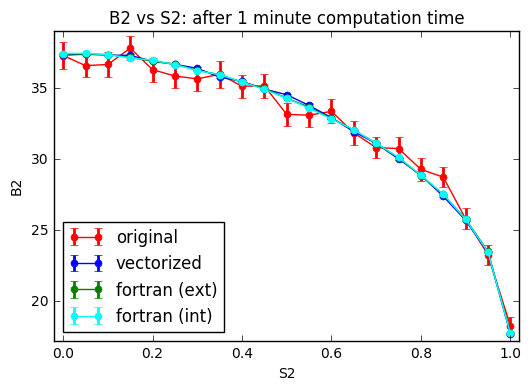

In [22]:
fortran_result=pd.read_csv("B2_L5d0_D1d0-race-csv.dat", header=None, names=["S2", "alpha", "B2", "error"])
plt.errorbar(output_table.S2, output_table.B2, output_table.error, color = "red", label="original", marker = ".", markersize='10', elinewidth=2)
plt.errorbar(output_table_vec.S2, output_table_vec.B2, output_table_vec.error, color="blue", label = "vectorized", marker = ".", markersize='10', elinewidth=2)
plt.errorbar(fortran_result.S2, fortran_result.B2, fortran_result.error, color="green", label = "fortran (ext)", marker = ".", markersize='10', elinewidth=2)
plt.errorbar(output_table_f2py.S2, output_table_f2py.B2, output_table_f2py.error, color="cyan", label = "fortran (int)", marker = ".", markersize='10', elinewidth=2)
plt.legend(loc="lower left")
plt.xlabel("S2")
plt.ylabel("B2")
plt.margins(0.02)
plt.title("B2 vs S2: after 1 minute computation time")
plt.show()

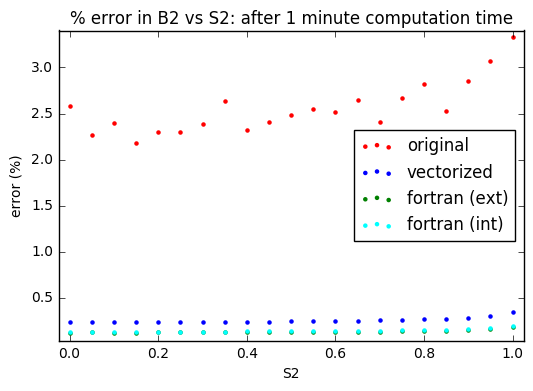

In [24]:
plt.scatter(output_table.S2, (output_table.error/output_table.B2)*100.0, color = "red", label="original", marker = ".")
plt.scatter(output_table_vec.S2, (output_table_vec.error/output_table_vec.B2)*100.0, color="blue", label = "vectorized", marker = ".")
plt.scatter(fortran_result.S2, (fortran_result.error/fortran_result.B2)*100.0, color="green", label = "fortran (ext)", marker = ".")
plt.scatter(output_table_f2py.S2, (output_table_f2py.error/output_table_f2py.B2)*100.0, color="cyan", label = "fortran (int)", marker = ".")
plt.legend(loc="center right")
plt.xlabel("S2")
plt.ylabel("error (%)")
plt.margins(0.02)
plt.title("% error in B2 vs S2: after 1 minute computation time")
plt.show()